### Non-Local Means Comparison

The purpose of this notebook is to create a baseline similarity comparison between the low-level intensity images using non-local means image processing algorithm with the high intensity cell images.

In [1]:
import numpy as np
import skimage 
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage import data, img_as_float, img_as_ubyte, io
from skimage.measure import compare_ssim as ssim
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009/test data_1_MMStack_Undefined1.ome.tif'
imsk = io.imread(path_to_data)
imsk.shape

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1752: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


(700, 512, 512)

In [3]:
# Convert everything to scaled floating values
scaled_imgs = []
for i in range(0,imsk.shape[0]):
#     print(imsk[i,:,:])
    scaled_imgs.append(img_as_float(imsk[i,:,:].astype(np.uint)))
print(scaled_imgs[0])

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))


[[1.08962318e-17 8.07730619e-18 1.11130723e-17 ... 1.17635936e-17
  9.64939934e-18 8.07730619e-18]
 [1.03541307e-17 1.05709712e-17 1.20346441e-17 ... 8.29414662e-18
  1.01372903e-17 1.04083409e-17]
 [8.72782749e-18 8.99887803e-18 1.39862080e-17 ... 9.86623977e-18
  1.14383329e-17 1.01915004e-17]
 ...
 [3.53449908e-17 3.13876529e-17 2.81892565e-17 ... 1.37693676e-17
  1.52330405e-17 1.20888542e-17]
 [2.97613496e-17 3.11708125e-17 2.82976767e-17 ... 1.26309553e-17
  1.37693676e-17 1.33356867e-17]
 [2.74845251e-17 2.54245409e-17 2.67797937e-17 ... 1.25767452e-17
  1.51788304e-17 1.50704102e-17]]


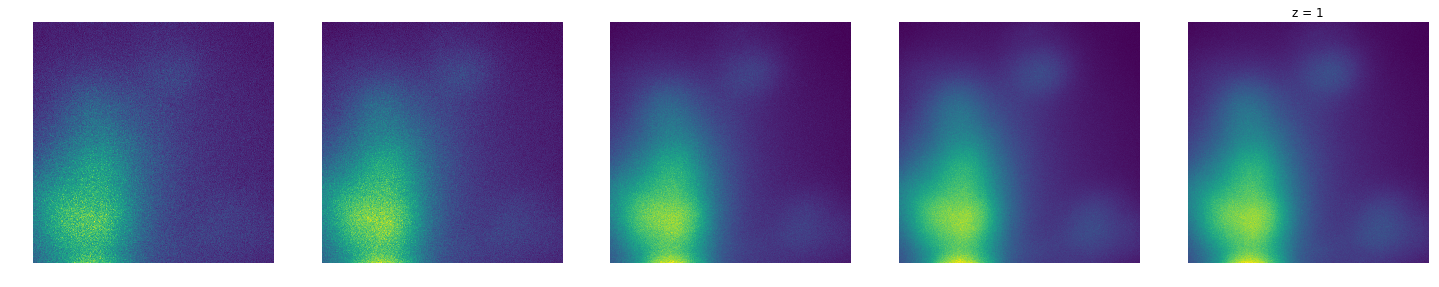

In [4]:
# for i in range(0,20,10):
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
ax[0].imshow(scaled_imgs[0]);
ax[0].axis('off')
ax[1].imshow(scaled_imgs[1]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs[2]);
ax[2].axis('off')
ax[3].imshow(scaled_imgs[4]);
ax[3].axis('off')
ax[4].imshow(scaled_imgs[5]);
ax[4].axis('off')
plt.title('z = '+str(1))
plt.show()

In [19]:
_min = scaled_imgs[5].min()
_max = scaled_imgs[5].max()
print(ssim(scaled_imgs[0],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[1],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[2],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[3],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[4],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[5],scaled_imgs[5],data_range=_max-_min))

0.2351745815481035
0.2965951636780404
0.6688529668488682
0.791309008088592
0.8066083320665349
1.0


In [22]:
denoised_imgs = []
for i, scaled_img in enumerate(scaled_imgs):
    print(i)
    denoised_imgs.append(denoise_nl_means(scaled_img))
    if i > 6:
        break

0
1
2
3
4
5
6
7


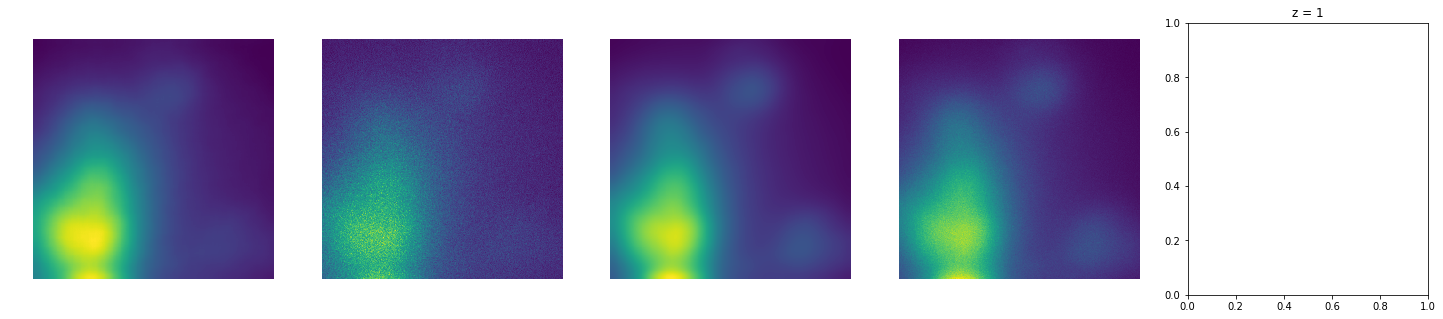

0.8830880183372031


In [28]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(denoised_imgs[0]);
ax[0].axis('off')
ax[1].imshow(scaled_imgs[0]);
ax[1].axis('off')
ax[2].imshow(denoised_imgs[5]);
ax[2].axis('off')
ax[3].imshow(scaled_imgs[5]);
ax[3].axis('off')
plt.title('z = '+str(1))
plt.show()

print(ssim(denoised_imgs[4],scaled_imgs[5],data_range=_max-_min))

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


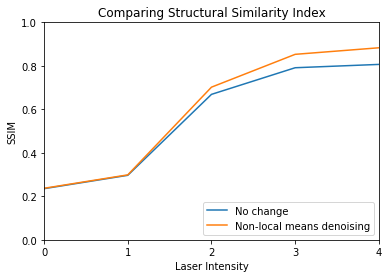

In [34]:
original_ssim = []
nl_ssim = []
for i in range(0,5):
    original_ssim.append(ssim(scaled_imgs[i],scaled_imgs[5],data_range=_max-_min))
    nl_ssim.append(ssim(denoised_imgs[i],scaled_imgs[5],data_range=_max-_min))

plt.plot(list(range(0, 5)), original_ssim, label="No change") 
plt.plot(list(range(0, 5)), nl_ssim, label="Non-local means denoising") 

plt.title('Comparing Structural Similarity Index')
plt.legend(loc = 'lower right')
plt.ylim([0, 1])
plt.xlim([0, 4])
plt.axes().set_xticks(list(range(0, 5)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Laser Intensity')
plt.show()

    
    